In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2 as cv
import warnings
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import itertools
import skimage.transform as st
from enum import Enum
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type='GPU')

2.4.0


In [2]:
seed = 2021
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Dnet

In [12]:
def get_data(data_split='test', test_type='NULL', target='NULL'):
    X_test = []
    y_test = []
    
    if (data_split == 'train'):
        filename = 'Data/mimic_train.tfrecords'
    elif(data_split == 'val'):
        filename = 'Data/mimic_val.tfrecords'
    else:
        filename = 'Data/mimic_test.tfrecords'
        
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        sub_y = []

        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
                
        ethnicity = example.features.feature['race'].int64_list.value[0]
        No_finding = example.features.feature['No Finding'].int64_list.value[0]
                        
        if (No_finding == 0):
            continue
            
        if (ethnicity == 0):
            label = tf.constant([1, 0, 0])
        elif (ethnicity == 1):
            label = tf.constant([0, 1, 0])
        elif (ethnicity == 4):
            label = tf.constant([0, 0, 1])
        else:
            continue

#         nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
#         img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

#         X_test.append(st.resize(img_np, (224, 224)))
        
        y_test.append(label)
                        
    return np.array(X_test), np.array(y_test)

In [21]:
X, y = get_data(data_split='train')
count = 0
for i in range(3):
    count += y[:, i].sum()
    print(y[:, i].sum())
count

25633
8353
1321


35307

In [6]:
INPUT_SHAPE = (224, 224, 1)
BATCH_SIZE = 128

init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def define_model():
    
    input = tf.keras.layers.Input(shape=INPUT_SHAPE)
    
    x = tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=1, padding='same', kernel_initializer=init, use_bias=False)(input)
    
    base_model = tf.keras.applications.densenet.DenseNet121(
            include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')(x)
         
    pred_layer = tf.keras.layers.Dense(3, activation='sigmoid')(base_model)
 
    model = tf.keras.Model(inputs=input, outputs=pred_layer)    
  
    return model

In [13]:
X_train, y_train = get_data(data_split='train')
X_val, y_val = get_data(data_split='val')

In [32]:
model = define_model()

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler)]

print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 224, 224, 3)       27        
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 7,040,606
Trainable params: 6,956,958
Non-trainable params: 83,648
_________________________________________________________________
None


In [33]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='AUC')

model.fit(X_train, y_train, epochs=5, shuffle=True, callbacks=callback, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/5
276/276 [==============================] - 112s 377ms/step - loss: 0.8925 - auc: 0.8772 - val_loss: 0.8148 - val_auc: 0.8286
Epoch 2/5
276/276 [==============================] - 103s 373ms/step - loss: 0.2818 - auc: 0.9635 - val_loss: 0.5186 - val_auc: 0.9145
Epoch 3/5
276/276 [==============================] - 103s 373ms/step - loss: 0.1912 - auc: 0.9773 - val_loss: 0.3757 - val_auc: 0.9329
Epoch 4/5
276/276 [==============================] - 104s 378ms/step - loss: 0.1394 - auc: 0.9827 - val_loss: 0.3753 - val_auc: 0.9520
Epoch 5/5
276/276 [==============================] - 103s 374ms/step - loss: 0.1225 - auc: 0.9855 - val_loss: 1.6092 - val_auc: 0.7258


In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.show()
    
def plot_roc(y_test, preds, title, label):
    fig = plt.figure(figsize=(8,6))

    num = len(label)
    for i in range(num):
        fpr, tpr, _ = roc_curve(y_test[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(label[i], roc_auc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    
    plt.savefig('Dnet_race_wba_auc.svg')
    
    plt.show()

In [24]:
def test(y_preds, y_test):
    
    n_bootstraps = 1000
    rng_seed = 2021  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_preds), len(y_preds))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_test[indices], y_preds[indices])
        bootstrapped_scores.append(score)
        
    plt.hist(bootstrapped_scores, bins=100)
    plt.title('Histogram of the bootstrapped ROC AUC scores')
    plt.show()
    
    auc_score = np.array(bootstrapped_scores)
    
    mean_score = auc_score.mean()
    std_dev = auc_score.std()
    std_error = std_dev / np.math.sqrt(1)
    ci =  2.262 * std_error
    lower_bound = mean_score - ci
    upper_bound = mean_score + ci

    print("Sample auc mean: {:0.2f}". format(mean_score))
    print("Samole auc std: {:0.2f}".format(std_dev))
    print("Sample auc CI: {:0.2f}". format(ci))
    print("Confidence interval for the score: [{:0.2f} - {:0.2f}]".format(
        lower_bound, upper_bound))

In [25]:
Labels_race = ['WHITE', 'AFRICAN AMERICAN', 'ASIA']

def plot(y_preds, y_test):

    plot_roc(y_test, y_preds, 'ROC', Labels_race)

    cm_race = [0 for i in range(len(Labels_race))]
    for i in range(len(Labels_race)):
        cm_race[i] = [0 for j in range(len(Labels_race))]

    preds = tf.one_hot(tf.argmax(y_preds, axis=1), len(Labels_race))
    for i in range(len(y_test)):
        cm_race[np.argmax(preds[i])][np.argmax(y_test[i])] += 1

    plot_confusion_matrix(np.array(cm_race).transpose(), 
                          normalize = False,
                          target_names = Labels_race,
                          title = 'CM')

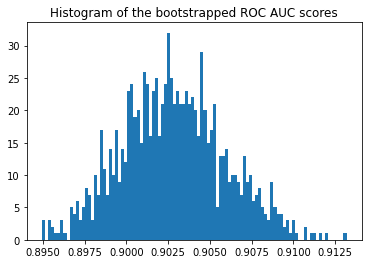

Sample auc mean: 0.90
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for the score: [0.90 - 0.91]


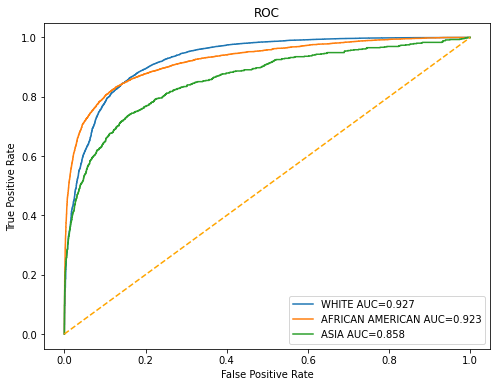

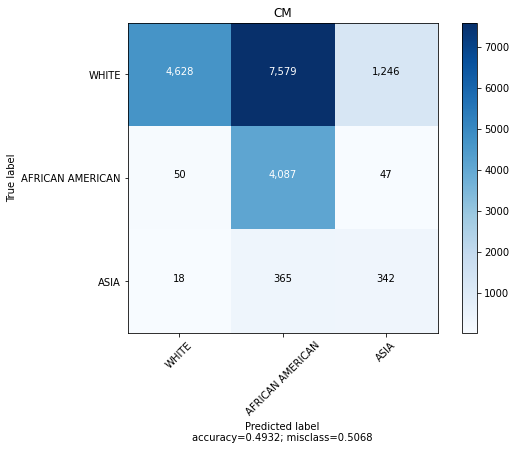

In [34]:
# model = tf.keras.models.load_model('saved_model/Dnet_race_No_finding')

# X_test, y_test = get_data()

y_preds = model.predict(X_test)
test(y_preds, y_test)
plot(y_preds, y_test)

In [35]:
model.save('saved_model/Dnet121_No_finding')

INFO:tensorflow:Assets written to: saved_model/Dnet121_No_finding/assets
